In [17]:
import os
import numpy as np
import pandas as pd
import gc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.read_excel('./dataset/Data_Dictionary.xlsx', header=2, sheet_name='train')

,Columns,Description
0,card_id,Unique card identifier
1,first_active_month,"'YYYY-MM', month of first purchase"
2,feature_1,Anonymized card categorical feature
3,feature_2,Anonymized card categorical feature
4,feature_3,Anonymized card categorical feature
5,target,Loyalty numerical score calculated 2 months af...


In [3]:
pd.read_csv('./dataset/sample_submission.csv', header=0).head(5)

,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
3,C_ID_d27d835a9f,0
4,C_ID_2b5e3df5c2,0


In [4]:
pd.read_csv('./dataset/sample_submission.csv', header=0).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   card_id  123623 non-null  object
 1   target   123623 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


In [6]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

In [7]:
(train.shape, test.shape)

((201917, 6), (123623, 5))

In the actual project process, since the labels of the test set are "unknown," it is necessary to split a validation set from the training set "train" to evaluate the model's generalization ability.

# Preprocessing

## Duplicates

In [10]:
train["card_id"].nunique() == train.shape[0]

True

In [11]:
test["card_id"].nunique() == test.shape[0]

True

In [12]:
test['card_id'].nunique()+ train['card_id'].nunique()  == len(set(test['card_id'].values.tolist() + train['card_id'].values.tolist()))

True

## Missing values

In [13]:
train.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [14]:
test.isnull().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

There is only 1 missing value in testset

## Abnormal values

In [16]:
statistics = train['target'].describe()
statistics

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

<Axes: xlabel='target', ylabel='Count'>

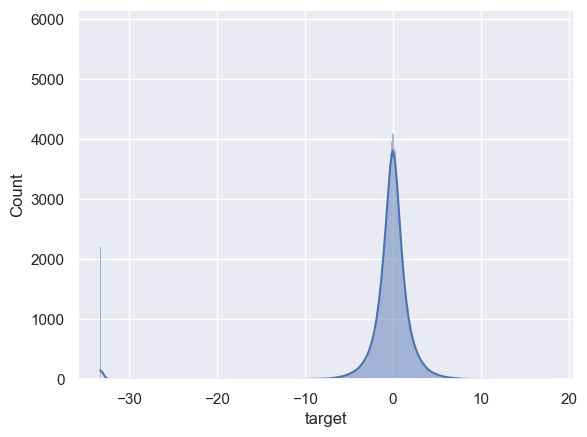

In [18]:
sns.set()
sns.histplot(train['target'], kde=True)

It can be noticed that the majority of user loyalty scores are clustered within the range of -10 to 10, and they generally conform to a normal distribution. The only point of concern is that there are a few outliers with values below -30. We should take special note of this data during subsequent analysis. Let's check how many users have label values less than 30:

In [19]:
(train['target'] < -30).sum()

2207

### Addressing the abnormal values with 3 sigma method

In [20]:
statistics.loc['mean'] - 3 * statistics.loc['std']

-11.945136285536142

The values which are less than -11.945 could be considered as abnormal

## Distributional Consistency Check

### For single feature

In [21]:
features = ['first_active_month','feature_1','feature_2','feature_3']
train_count = train.shape[0]
test_count = test.shape[0]

<Axes: >

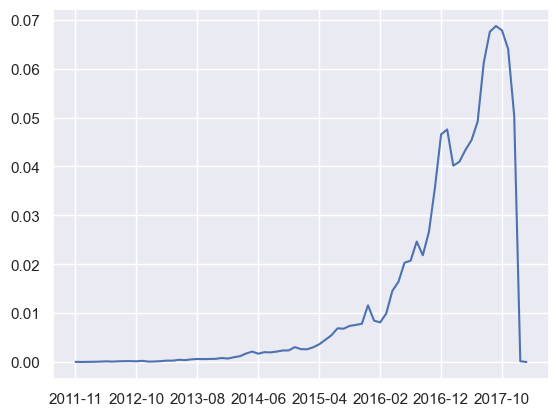

In [22]:
# train['first_active_month'].value_counts().sort_index()/train_count
(train['first_active_month'].value_counts().sort_index()/train_count).plot()

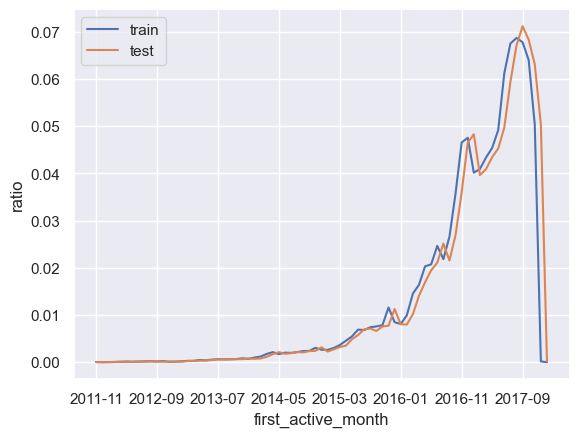

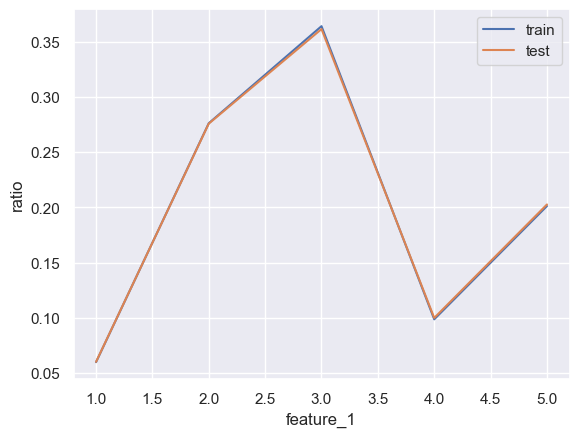

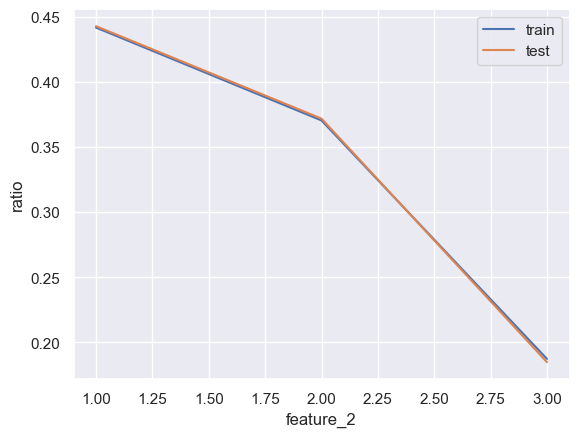

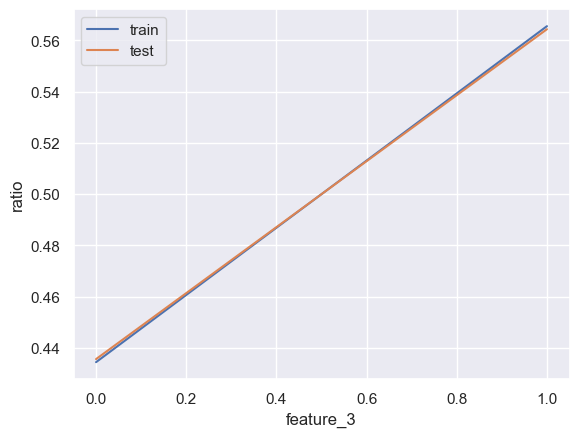

In [23]:
for feature in features:
    (train[feature].value_counts().sort_index()/train_count).plot()
    (test[feature].value_counts().sort_index()/test_count).plot()
    plt.legend(['train','test'])
    plt.xlabel(feature)
    plt.ylabel('ratio')
    plt.show()

### Multivariate joint distribution.

In [24]:
def combine_feature(df):
    cols = df.columns
    feature1 = df[cols[0]].astype(str).values.tolist()
    feature2 = df[cols[1]].astype(str).values.tolist()
    return pd.Series([feature1[i]+'&'+feature2[i] for i in range(df.shape[0])])

In [25]:
cols = [features[0], features[1]]
train_com = combine_feature(train[cols])
train_dis = train_com.value_counts().sort_index()/train_count
test_dis = combine_feature(test[cols]).value_counts().sort_index()/test_count

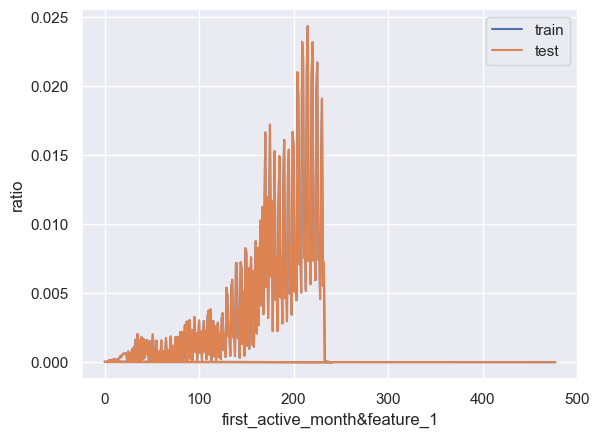

In [26]:
# create new index
index_dis = pd.Series(train_dis.index.tolist() + test_dis.index.tolist()).drop_duplicates().sort_values()

# fill 0 to missing values
(index_dis.map(train_dis).fillna(0)).plot()
(index_dis.map(train_dis).fillna(0)).plot()

plt.legend(['train','test'])
plt.xlabel('&'.join(cols))
plt.ylabel('ratio')
plt.show()

['first_active_month', 'feature_1']


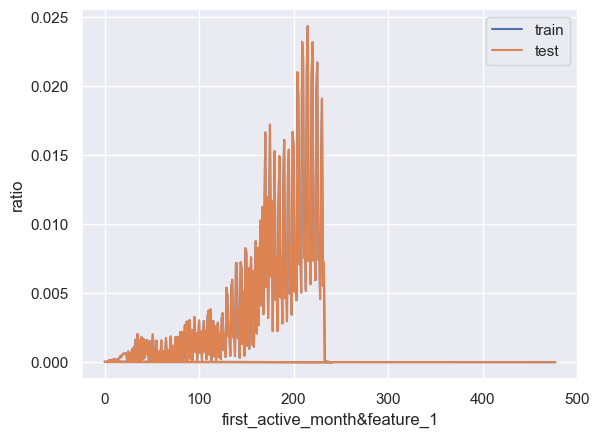

['first_active_month', 'feature_2']


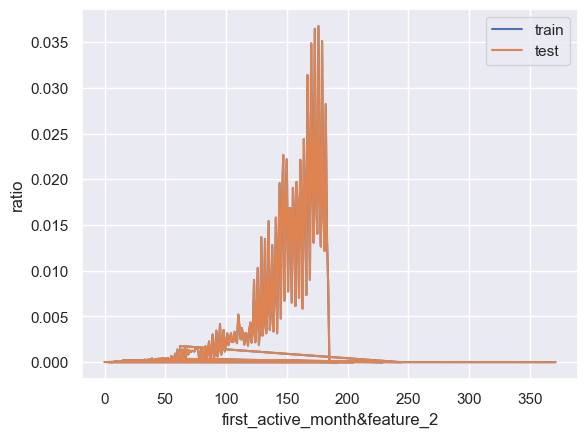

['first_active_month', 'feature_3']


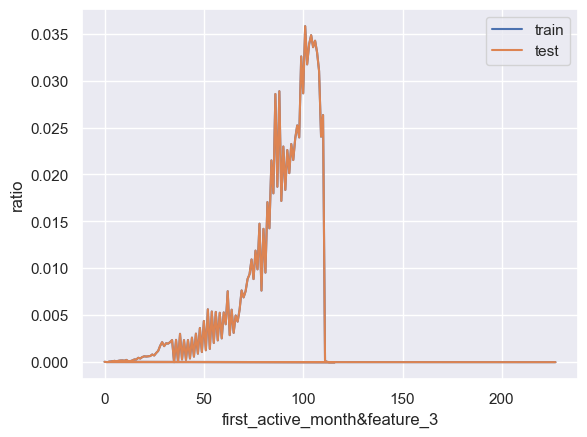

['feature_1', 'feature_2']


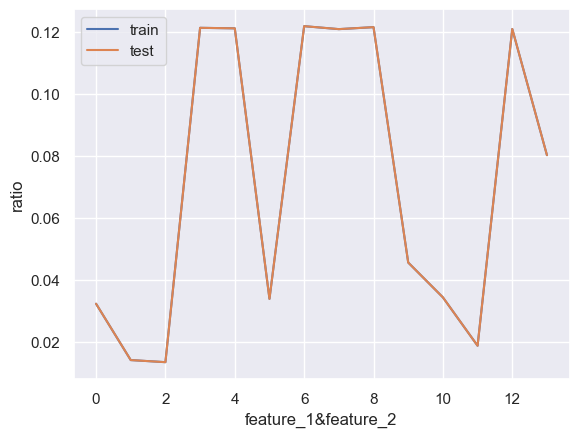

['feature_1', 'feature_3']


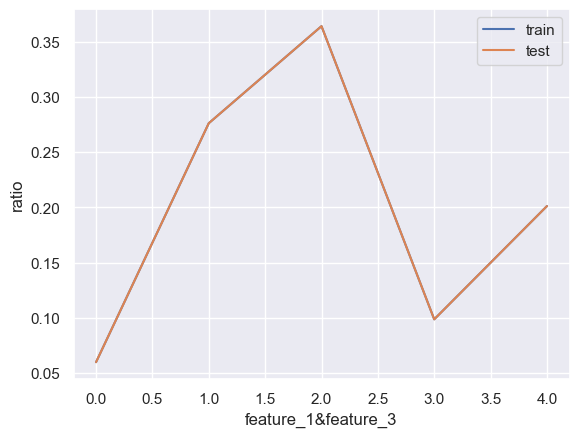

['feature_2', 'feature_3']


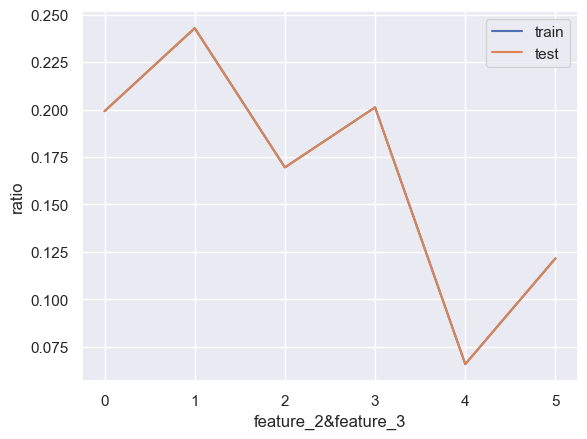

In [27]:
n = len(features)
for i in range(n-1):
    for j in range(i+1, n):
        cols = [features[i], features[j]]
        print(cols)
        train_dis = combine_feature(train[cols]).value_counts().sort_index()/train_count
        test_dis = combine_feature(test[cols]).value_counts().sort_index()/test_count
        index_dis = pd.Series(train_dis.index.tolist() + test_dis.index.tolist()).drop_duplicates().sort_values()
        (index_dis.map(train_dis).fillna(0)).plot()
        (index_dis.map(train_dis).fillna(0)).plot()
        plt.legend(['train','test'])
        plt.xlabel('&'.join(cols))
        plt.ylabel('ratio')
        plt.show()

It can be observed that the proportion distribution of all joint variables is generally consistent. The overall quality of the dataset is high, and it can be reasonably confirmed that the training set and the test set are drawn from the same population.